## 多因子模型

In [12]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from utils import *
import os
import joblib

In [13]:
def mse1(y_true, y_pred):
    if(y_true is None or y_pred is None):
        return 0
    
    return np.mean((y_true - y_pred)**2)

In [14]:
start_date = '2011-04-30'
end_date = '2018-04-30'

In [15]:
df_all = pd.read_csv('data/df_all.csv', dtype={'asset': str})
df_all['date'] = pd.to_datetime(df_all['date'])

# df_all = df_all[(df_all['date'] >= start_date) & (df_all['date'] <= end_date)]

df_all.drop(['Unnamed: 0', 'Rmrf', 'Smb', 'Hml'], axis=1, inplace=True)
df_all_pivot = df_all.pivot(index='date', columns='asset')

In [16]:
df_all_pivot.columns

MultiIndex([('open', '000001'),
            ('open', '000002'),
            ('open', '000009'),
            ('open', '000012'),
            ('open', '000021'),
            ('open', '000027'),
            ('open', '000031'),
            ('open', '000039'),
            ('open', '000046'),
            ('open', '000059'),
            ...
            (  'ep', '601898'),
            (  'ep', '601899'),
            (  'ep', '601918'),
            (  'ep', '601919'),
            (  'ep', '601939'),
            (  'ep', '601958'),
            (  'ep', '601988'),
            (  'ep', '601989'),
            (  'ep', '601991'),
            (  'ep', '601998')],
           names=[None, 'asset'], length=7776)

In [17]:
print("已经有的因子：")
df_all.columns

已经有的因子：


Index(['asset', 'date', 'open', 'close', 'high', 'low', 'volume', 'amount',
       'vwap', 'pctChg', 'turnover', 'benchmark_open', 'benchmark_close',
       'benchmark_high', 'benchmark_low', 'benchmark_vol', 'roe', 'roa', 'cvd',
       'epq', 'emq', 'sgq', 'alaq', 'pmq', 'cta', 'size', 'rf', 'bm', 'ep'],
      dtype='object')

In [18]:
returns = pd.read_csv('data/returns.csv', index_col=0)
returns.index = pd.to_datetime(returns.index)
all_time_index = returns.index
all_time_index

# returns = returns[(returns.index >= start_date) & (returns.index <= end_date)]

# return_copy = returns.copy()
# return_copy = return_copy[(return_copy.index >= start_date) & (return_copy.index <= end_date)]

# dates = return_copy.index
# dates

DatetimeIndex(['2011-05-03', '2011-05-04', '2011-05-05', '2011-05-06',
               '2011-05-09', '2011-05-10', '2011-05-11', '2011-05-12',
               '2011-05-13', '2011-05-16',
               ...
               '2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20',
               '2023-04-21', '2023-04-24', '2023-04-25', '2023-04-26',
               '2023-04-27', '2023-04-28'],
              dtype='datetime64[ns]', name='date', length=2918, freq=None)

In [19]:
returns.columns
assets = returns.columns

In [20]:
# 从因子数据中读取因子
alphaset = 'ourAlphas'
subset = '20110430'

from MyBacktrader import get_alpha_list

alpha_names = get_alpha_list(f'alphas/{alphaset}/{subset}')
# alpha_names = ['alpha_financial_health']

for alpha_name in alpha_names:
    alpha = pd.read_csv('alphas/{}/{}/{}.csv'.format(alphaset, subset, alpha_name))
    
    # 从因子数据中读取因子
    alpha = alpha.set_index('date')
    alpha.index = pd.to_datetime(alpha.index)
    
    # alpha = alpha[(alpha.index >= start_date) & (alpha.index <= end_date)]

    # 给 alpha 添加双重索引
    alpha.columns = pd.MultiIndex.from_product([[f'{alpha_name}'], alpha.columns], names=['', 'asset'])

    # 合并 alpha 到 df_all_pivot
    df_all_pivot = pd.concat([df_all_pivot, alpha], axis=1)

    # print(df_combined)
    # 合并到df_all_pivot
    # df_all_pivot = pd.concat([df_all_pivot, alpha], axis=1)

In [21]:
print("已经有的因子：")
print(df_all_pivot.columns.get_level_values(0).unique())

已经有的因子：
Index(['open', 'close', 'high', 'low', 'volume', 'amount', 'vwap', 'pctChg',
       'turnover', 'benchmark_open', 'benchmark_close', 'benchmark_high',
       'benchmark_low', 'benchmark_vol', 'roe', 'roa', 'cvd', 'epq', 'emq',
       'sgq', 'alaq', 'pmq', 'cta', 'size', 'rf', 'bm', 'ep', 'alpha001',
       'alpha_ALAQ', 'alpha_bm', 'alpha_CTA', 'alpha_CVD', 'alpha_EMQ',
       'alpha_EP', 'alpha_EPQ', 'alpha_Fama_French', 'alpha_financial_health',
       'alpha_High_Low', 'alpha_liquidity', 'alpha_market_alpha',
       'alpha_momentum', 'alpha_momentum_60', 'alpha_multi', 'alpha_PMQ',
       'alpha_PMQ_momentum', 'alpha_Price_VWAP', 'alpha_reversal',
       'alpha_Rmrf', 'alpha_ROA_momentum', 'alpha_ROE', 'alpha_ROE_ROA',
       'alpha_rsi', 'alpha_sentiment', 'alpha_SGQ', 'alpha_SGQ_volatility',
       'alpha_size', 'alpha_trade_density', 'alpha_turnover',
       'alpha_turnover_10', 'alpha_turnover_month', 'alpha_Volume_Close',
       'alpha_vol_skew'],
      dtype='object')


## 三因子：FamaFrench

In [22]:
Y = returns - df_all_pivot['rf'].values
# print(Y.head())

# 截取时间段
Y = Y[(Y.index >= start_date) & (Y.index <= end_date)]

X_fama = df_all_pivot[['alpha_size', 'alpha_bm', 'alpha_Rmrf']]

X_fama = X_fama[(X_fama.index >= start_date) & (X_fama.index <= end_date)]

X_fama.columns.get_level_values(0).unique()

# 提取资产列表（多重索引的第二层）
assets = X_fama.columns.get_level_values(1).unique()
# assets = ['601939']
dates = Y.index

# 创建 DataFrame 存储回归结果
expected_columns = ['Asset'] + list(X_fama.columns.get_level_values(0).unique()) + ['Intercept']

famafrench_models = {}

total_mse_famafrench = 0

# 对每个资产进行回归
for asset in tqdm(assets):
    # print("asset: ", asset)
    # 提取该资产对应的 Y 和 X
    y = Y[asset].dropna()
    x = X_fama.xs(asset, axis=1, level=1).reindex(y.index)  # 确保时间对齐

    # 添加常数项
    x = sm.add_constant(x)

    # 找出缺失的列
    missing_columns = [col for col in expected_columns if col not in x.columns and col != 'Asset']
    
    # 手动补充缺失列
    for col in missing_columns:
        x[col] = 0

    # 确保列顺序一致
    x = x[expected_columns[1:]]  # 排除 'Asset'，其余列按 expected_columns 的顺序排列
    
    # 回归分析
    model = sm.OLS(y, x).fit()
    
    pred = model.predict(x)
    
    # 计算 MSE
    mse_val = mse1(y, pred)
    
    total_mse_famafrench += mse_val
    
    # 保存回归模型
    famafrench_models[asset] = model
    
    # 如果路径不存在，创建路径
    if not os.path.exists('models/famafrench_models'):
        os.makedirs('models/famafrench_models')
    
    joblib.dump(model, f'models/famafrench_models/{asset}.pkl')

    # # 回归分析
    # model = sm.OLS(y, x).fit()
    
    # pred = model.predict(x)
    # regression_preds[asset] = pred

    # # 计算 MSE
    # mse_val = mse1(y, pred)
    # total_mse_regression += mse_val

    # # 记录回归结果
    # result = [asset] + list(model.params.reindex(expected_columns[1:]).fillna(0).values)
    
    # # 保存回归模型
    # regression_models[asset] = model

    # 检查 result 的长度和 regression_betas 的列数
    # print("result 的长度:", len(result))
    # print("regression_betas 的列数:", len(regression_betas.columns))

    # regression_betas.loc[len(regression_betas)] = result
    

# 设置列名
# regression_betas.columns = ['Asset'] + list(X.columns.get_level_values(0).unique()) + ['Intercept']

print("MSE:")
print(total_mse_famafrench)

100%|██████████| 288/288 [00:01<00:00, 172.51it/s]

MSE:
212.3532906973485


## 三因子：CH3

In [24]:
Y = returns - df_all_pivot['rf'].values
# print(Y.head())

# 截取时间段
Y = Y[(Y.index >= start_date) & (Y.index <= end_date)]

X_ch3 = df_all_pivot[['alpha_size', 'alpha_EP', 'alpha_turnover', 'alpha_Rmrf']]

X_ch3 = X_ch3[(X_ch3.index >= start_date) & (X_ch3.index <= end_date)]

X_ch3.columns.get_level_values(0).unique()

# 提取资产列表（多重索引的第二层）
assets = X_ch3.columns.get_level_values(1).unique()
# assets = ['601939']
dates = Y.index

# 创建 DataFrame 存储回归结果
expected_columns = ['Asset'] + list(X_ch3.columns.get_level_values(0).unique()) + ['Intercept']

ch3_models = {}

total_mse_ch3 = 0

# 对每个资产进行回归
for asset in tqdm(assets):
    # print("asset: ", asset)
    # 提取该资产对应的 Y 和 X
    y = Y[asset].dropna()
    x = X_ch3.xs(asset, axis=1, level=1).reindex(y.index)  # 确保时间对齐

    # 添加常数项
    x = sm.add_constant(x)

    # 找出缺失的列
    missing_columns = [col for col in expected_columns if col not in x.columns and col != 'Asset']
    
    # 手动补充缺失列
    for col in missing_columns:
        x[col] = 0

    # 确保列顺序一致
    x = x[expected_columns[1:]]  # 排除 'Asset'，其余列按 expected_columns 的顺序排列
    
    # 回归分析
    model = sm.OLS(y, x).fit()
    
    pred = model.predict(x)
    
    # 计算 MSE
    mse_val = mse1(y, pred)
    
    total_mse_ch3 += mse_val
    
    # 保存回归模型
    ch3_models[asset] = model
    
    # 如果路径不存在，创建路径
    if not os.path.exists('models/ch3_models'):
        os.makedirs('models/ch3_models')
    
    joblib.dump(model, f'models/ch3_models/{asset}.pkl')

    # # 回归分析
    # model = sm.OLS(y, x).fit()
    
    # pred = model.predict(x)
    # regression_preds[asset] = pred

    # # 计算 MSE
    # mse_val = mse1(y, pred)
    # total_mse_regression += mse_val

    # # 记录回归结果
    # result = [asset] + list(model.params.reindex(expected_columns[1:]).fillna(0).values)
    
    # # 保存回归模型
    # regression_models[asset] = model

    # 检查 result 的长度和 regression_betas 的列数
    # print("result 的长度:", len(result))
    # print("regression_betas 的列数:", len(regression_betas.columns))

    # regression_betas.loc[len(regression_betas)] = result
    

# 设置列名
# regression_betas.columns = ['Asset'] + list(X.columns.get_level_values(0).unique()) + ['Intercept']

print("MSE:")
print(total_mse_ch3)

  0%|          | 0/288 [00:00<?, ?it/s]

100%|██████████| 288/288 [00:01<00:00, 166.48it/s]

MSE:
211.07034109889813


In [29]:
# 保存预测结果为因子形式

import os
from utils import rank

def save_to_factors_three(X, model_name = 'ch3'):
    results_pred = pd.DataFrame(index=all_time_index, columns=assets)
    for asset_id in tqdm(assets):
        if(model_name == 'famafrench'):
            model = famafrench_models[asset_id]
        else:
            model = ch3_models[asset_id]
            
        selected_vars = model.params.index.tolist()
        
        isIntercept = False
        if('Intercept' in selected_vars):
                isIntercept = True
        isconst = False
        if('const' in selected_vars):
                isconst = True
        
        selected_vars = [var for var in selected_vars if var != 'const' and var != 'Intercept']
        
        # print(model.params)
        
        # print(model.params.shape)
        X2 = X.xs(asset_id, axis=1, level=1)[selected_vars]
        
        if 'const' not in X2.columns and isconst:
                X2 = sm.add_constant(X2)
        if isIntercept:
                X2['Intercept'] = 1
                
        # print(X2.columns)
        
        pred = model.predict(X2)
        
        pred = pd.Series(pred, index=all_time_index)
        
        results_pred[asset_id] = pred
    
    results_pred = rank(results_pred)
        
    # 如果路径不存在，创建路径
    if not os.path.exists('alphas/multialpha'):
        os.makedirs('alphas/multialpha')
    
    results_pred.to_csv(f'alphas/multialpha/20110430/alpha_{model_name}.csv')


In [30]:
save_to_factors_three(X_fama, 'famafrench')
save_to_factors_three(X_ch3, 'ch3')

100%|██████████| 288/288 [00:00<00:00, 1010.06it/s]


## 选择因子

In [10]:
Y = returns - df_all_pivot['rf'].values
# print(Y.head())

# 截取时间段
Y = Y[(Y.index >= start_date) & (Y.index <= end_date)]

X = df_all_pivot.drop(['rf', 'alpha_Fama_French', 'open', 'close', 'high', 'low', 'volume', 'amount', 'pctChg', 'cta', 'roe','vwap', 'pctChg',
       'turnover', 'benchmark_open', 'benchmark_close', 'benchmark_high',
       'benchmark_low', 'benchmark_vol', 'roe', 'roa', 'cvd', 'epq', 'emq',
       'sgq', 'alaq', 'pmq', 'cta', 'size', 'rf', 'bm'], axis=1, level=0)

X = X[(X.index >= start_date) & (X.index <= end_date)]

X.columns.get_level_values(0).unique()

Index(['alpha001', 'alpha_ALAQ', 'alpha_bm', 'alpha_CTA', 'alpha_CVD',
       'alpha_EMQ', 'alpha_EPQ', 'alpha_financial_health', 'alpha_High_Low',
       'alpha_liquidity', 'alpha_market_alpha', 'alpha_momentum',
       'alpha_momentum_60', 'alpha_multi', 'alpha_PMQ', 'alpha_PMQ_momentum',
       'alpha_Price_VWAP', 'alpha_reversal', 'alpha_ROA_momentum', 'alpha_ROE',
       'alpha_ROE_ROA', 'alpha_rsi', 'alpha_sentiment', 'alpha_SGQ',
       'alpha_SGQ_volatility', 'alpha_size', 'alpha_trade_density',
       'alpha_turnover', 'alpha_turnover_10', 'alpha_turnover_month',
       'alpha_Volume_Close', 'alpha_vol_skew'],
      dtype='object')

In [11]:
X.index

DatetimeIndex(['2011-05-03', '2011-05-04', '2011-05-05', '2011-05-06',
               '2011-05-09', '2011-05-10', '2011-05-11', '2011-05-12',
               '2011-05-13', '2011-05-16',
               ...
               '2018-04-16', '2018-04-17', '2018-04-18', '2018-04-19',
               '2018-04-20', '2018-04-23', '2018-04-24', '2018-04-25',
               '2018-04-26', '2018-04-27'],
              dtype='datetime64[ns]', name='date', length=1702, freq=None)

## 逐步回归

In [13]:
def stepwise_regression(y, X, direction='both', threshold_in=0.05, threshold_out=0.10):
    """
    逐步回归方法，进行特征选择，返回最优模型以及选择的特征
    :param y: 目标变量（依赖变量）
    :param X: 特征变量（自变量）
    :param direction: 选择方法：'forward'、'backward' 或 'both'
    :param threshold_in: 进入模型的显著性水平
    :param threshold_out: 离开模型的显著性水平
    :return: 最优模型以及选择的特征
    """
    initial_vars = X.columns.tolist()
    best_aic = float('inf')
    best_model = None
    remaining_vars = initial_vars.copy()
    selected_vars = []

    while True:
        changed = False
        
        if direction in ['both', 'forward']:  # 前向选择
            # 遍历所有未进入模型的变量
            for var in remaining_vars:
                model = sm.OLS(y, sm.add_constant(X[selected_vars + [var]])).fit()
                aic = model.aic
                # 仅当 AIC 更低时才加入该变量
                if aic < best_aic:
                    best_aic = aic
                    best_model = model
                    best_var = var
                    changed = True
                    selected_vars.append(best_var)
                    remaining_vars.remove(best_var)
                    break  # 只选择一个变量后继续向前

        if direction in ['both', 'backward']:  # 后向剔除
            # 遍历所有已进入模型的变量
            for var in selected_vars:
                temp_selected_vars = selected_vars.copy()
                temp_selected_vars.remove(var)
                model = sm.OLS(y, sm.add_constant(X[temp_selected_vars])).fit()
                aic = model.aic
                # 仅当 AIC 更低时才剔除该变量
                if aic < best_aic:
                    best_aic = aic
                    best_model = model
                    best_var = var
                    changed = True
                    selected_vars.remove(best_var)
                    break  # 只剔除一个变量后继续向后

        if not changed:
            break  # 没有变化，退出循环

    return best_model, selected_vars  # 返回最优模型及选择的特征

In [ ]:
import joblib

# 提取资产列表（多重索引的第二层）
assets = X.columns.get_level_values(1).unique()
# assets = ['601939']
dates = Y.index

# 创建 DataFrame 存储回归结果
regression_betas = pd.DataFrame(columns=['Asset'] + list(X.columns.get_level_values(0).unique()) + ['Intercept'])
expected_columns = ['Asset'] + list(X.columns.get_level_values(0).unique()) + ['Intercept']

regression_models = {}
regression_preds = pd.DataFrame(index=dates, columns=assets)

total_mse_regression = 0

# # 对每个资产进行回归
# for asset in tqdm(assets):
#     # print("asset: ", asset)
#     # 提取该资产对应的 Y 和 X
#     y = Y[asset].dropna()
#     x = X.xs(asset, axis=1, level=1).reindex(y.index)  # 确保时间对齐

#     # 添加常数项
#     x = sm.add_constant(x)

#     # 找出缺失的列
#     missing_columns = [col for col in expected_columns if col not in x.columns and col != 'Asset']
    
#     # 手动补充缺失列
#     for col in missing_columns:
#         x[col] = 0

#     # 确保列顺序一致
#     x = x[expected_columns[1:]]  # 排除 'Asset'，其余列按 expected_columns 的顺序排列
    
#     # 对特征进行逐步回归
#     stepwise_model, selected_vars = stepwise_regression(y, x)

#     # print(selected_vars)
#     # print(stepwise_model.summary())
    
#     # 获取逐步回归后的预测值
#     pred = stepwise_model.predict(sm.add_constant(x[selected_vars]))  # 用最终选择的特征进行预测
#     regression_preds[asset] = pred

#     # 计算 MSE
#     mse_val = mse1(y, pred)
#     total_mse_regression += mse_val

#     # 记录回归结果
#     result = [asset] + list(stepwise_model.params.reindex(expected_columns[1:]).fillna(0).values)
    
#     # 保存回归模型
#     regression_models[asset] = stepwise_model
    
#     # 如果路径不存在，创建路径
#     if not os.path.exists('models/regression_models'):
#         os.makedirs('models/regression_models')
    
#     joblib.dump(stepwise_model, f'models/regression_models/{asset}.pkl')

#     # # 回归分析
#     # model = sm.OLS(y, x).fit()
    
#     # pred = model.predict(x)
#     # regression_preds[asset] = pred

#     # # 计算 MSE
#     # mse_val = mse1(y, pred)
#     # total_mse_regression += mse_val

#     # # 记录回归结果
#     # result = [asset] + list(model.params.reindex(expected_columns[1:]).fillna(0).values)
    
#     # # 保存回归模型
#     # regression_models[asset] = model

#     # 检查 result 的长度和 regression_betas 的列数
#     # print("result 的长度:", len(result))
#     # print("regression_betas 的列数:", len(regression_betas.columns))

#     # regression_betas.loc[len(regression_betas)] = result
    

# # 设置列名
# # regression_betas.columns = ['Asset'] + list(X.columns.get_level_values(0).unique()) + ['Intercept']

# print("MSE:")
# print(total_mse_regression)

100%|██████████| 288/288 [03:46<00:00,  1.27it/s]

MSE:
145.8795948796848


In [ ]:
# 在models文件夹中循环读取模型
import os

# 读取模型
regression_models = {}

# 遍历 'models' 文件夹中的所有文件
models_folder = 'models/regression_models'  # 替换为你的模型文件夹路径
for filename in os.listdir(models_folder):
    if filename.endswith('.pkl'):  # 根据文件扩展名选择模型文件
        model_path = os.path.join(models_folder, filename)
        model_name = os.path.splitext(filename)[0]  # 获取文件名作为模型的名称

        # 读取模型并存入字典
        regression_models[model_name] = joblib.load(model_path)

## XGBoost

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import numpy as np



# 获取资产列表
asset_list = X.columns.get_level_values(1).unique()

# 存储每个资产的 XGBoost 模型和预测结果
xgb_models = {}
xgb_preds = pd.DataFrame(index=dates, columns=asset_list)

total_mse_xgb = 0

# # 对每个资产进行回归
# for asset_id in tqdm(asset_list):
#     # 提取资产对应的 Y 和 X
#     target_y = Y[asset_id].dropna()
#     feature_x = X.xs(asset_id, axis=1, level=1).reindex(target_y.index)
    
#     # 划分训练集和测试集，使用最后 20% 的数据作为测试集
#     train_size = int(0.8 * len(feature_x))
#     X_train, X_test = feature_x[:train_size], feature_x[train_size:]
#     y_train, y_test = target_y[:train_size], target_y[train_size:]

#     # 使用交叉验证选择最佳模型
#     param_grid = {
#         'n_estimators': [50, 100, 200],  # 决策树数量
#         'learning_rate': [0.01, 0.05, 0.1],  # 学习率
#         'max_depth': [3, 5, 7],  # 最大树深度
#         'reg_alpha': [0, 0.1, 1],  # L1 正则化
#         'reg_lambda': [0, 0.1, 1],  # L2 正则化
#     }
    
#     best_model = None
#     best_score = float('inf')  # 用于记录最优模型的评分
    
#     # 交叉验证（5折交叉验证）
#     kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
#     for n_estimators in param_grid['n_estimators']:
#         for learning_rate in param_grid['learning_rate']:
#             for max_depth in param_grid['max_depth']:
#                 xgb_regressor = XGBRegressor(
#                     n_estimators=n_estimators,
#                     learning_rate=learning_rate,
#                     max_depth=max_depth,
#                     random_state=42
#                 )
                
#                 # 交叉验证评分
#                 scores = cross_val_score(xgb_regressor, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
#                 mean_score = -scores.mean()  # 负 MSE 转为正值
                
#                 # 选择最优模型
#                 if mean_score < best_score:
#                     best_score = mean_score
#                     best_model = xgb_regressor
                
#     # 使用最优超参数训练模型
#     best_model.fit(X_train, y_train)

#     # 保存最佳模型
#     # xgb_models[asset_id] = best_model
#     joblib.dump(best_model, f'models/xgb_models/{asset_id}.pkl')

#     # 预测
#     xgb_pred = pd.DataFrame(best_model.predict(X_test), index=X_test.index, columns=[asset_id])

#     # 保存预测结果
#     # xgb_preds[asset_id] = xgb_pred

#     # 计算测试集上的 MSE
#     mse1 = mean_squared_error(y_test, xgb_pred)
#     total_mse_xgb += mse1
#     # print(f"Asset {asset_id} MSE: {mse}")

# # 输出所有资产的总 MSE
# average_mse_xgb = total_mse_xgb / len(asset_list)
# print(f"Average MSE across all assets: {average_mse_xgb}")

In [16]:
# 在models文件夹中循环读取模型
import os

# 读取模型
xgb_models = {}

# 遍历 'models' 文件夹中的所有文件
models_folder = 'models/xgb_models'  # 替换为你的模型文件夹路径
for filename in os.listdir(models_folder):
    if filename.endswith('.pkl'):  # 根据文件扩展名选择模型文件
        model_path = os.path.join(models_folder, filename)
        model_name = os.path.splitext(filename)[0]  # 获取文件名作为模型的名称

        # 读取模型并存入字典
        xgb_models[model_name] = joblib.load(model_path)

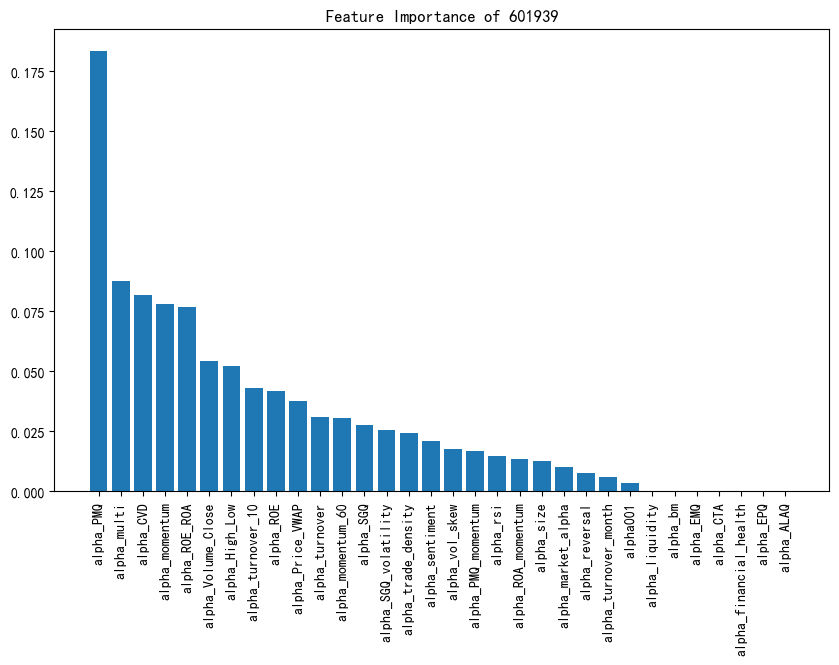

In [17]:
import matplotlib.pyplot as plt
from xgboost import plot_importance
import matplotlib

# 让图像可以在notebook中展示
%matplotlib inline

# 选择一个特定的资产，比如 '601939'
asset_id = '601939'

# 提取该资产对应的 XGBoost 模型
xgb_model = xgb_models[asset_id]

summary = pd.DataFrame(xgb_model.feature_importances_, index=X.columns.get_level_values(0).unique(), columns=['Importance'])
summary = summary.sort_values(by='Importance', ascending=False)

# 画图
plt.figure(figsize=(10, 6))
plt.bar(summary.index, summary['Importance'])
plt.xticks(rotation=90)
plt.title(f'Feature Importance of {asset_id}')
plt.show()


In [18]:
# 画散点图
plt.rcParams['axes.unicode_minus'] = False
def plot_y_and_pred(y, pred, asset_id, ifshow=True):
    plt.figure(figsize=(10, 6))
    plt.scatter(y.index, y, label='True', s = 5)
    plt.scatter(pred.index, pred, label='Predicted', s = 5)
    plt.title(f'True and Predicted Returns of {asset_id}')
    plt.legend()
    
    if ifshow:
        plt.show()
        
    else:
        plt.savefig(f'output_charts/predicts/{asset_id}.png')
        plt.close()

In [19]:
assets

Index(['000001', '000002', '000009', '000012', '000021', '000027', '000031',
       '000039', '000046', '000059',
       ...
       '601898', '601899', '601918', '601919', '601939', '601958', '601988',
       '601989', '601991', '601998'],
      dtype='object', name='asset', length=288)

(2918, 9216) (2918,) (2918,)
Test MSE: 0.6943563695889465


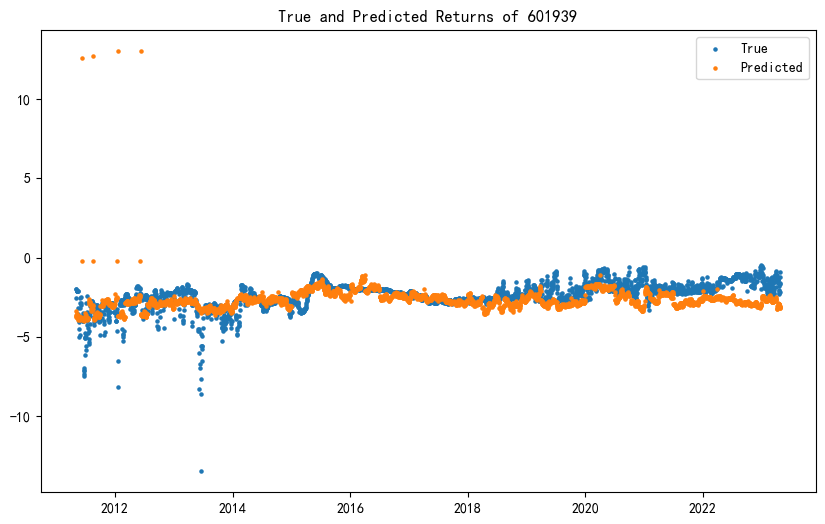

(2918, 9216) (2918,) (2918,)
Test MSE: 0.6646373183043105


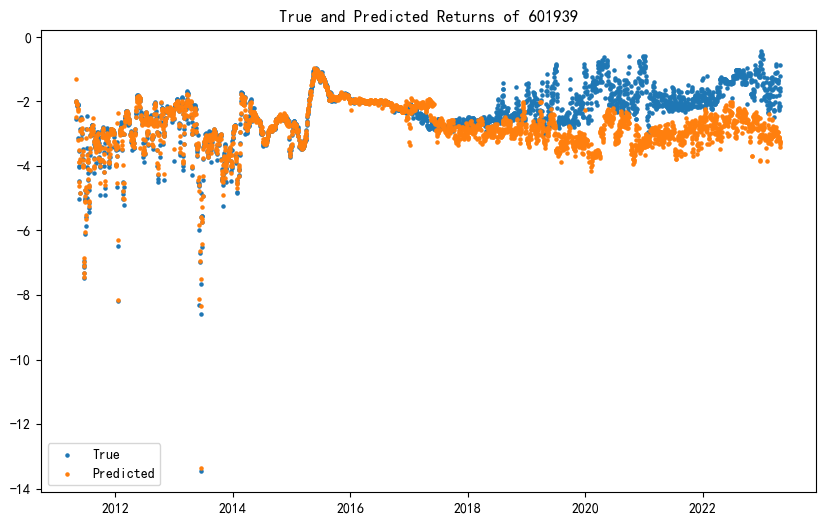

In [73]:
# 提取该资产对应的 Y 和 pred
y1 = returns - df_all_pivot['rf'].values
index_all = y1.index
X1 = df_all_pivot.drop(['rf', 'alpha_Fama_French', 'open', 'close', 'high', 'low', 'volume', 'amount', 'pctChg', 'cta', 'roe','vwap', 'pctChg',
       'turnover', 'benchmark_open', 'benchmark_close', 'benchmark_high',
       'benchmark_low', 'benchmark_vol', 'roe', 'roa', 'cvd', 'epq', 'emq',
       'sgq', 'alaq', 'pmq', 'cta', 'size', 'rf', 'bm'], axis=1, level=0)

def plot_test_pred(y, X, asset_id, ifshow=True, isXgb=True):
       y1 = y[asset_id].dropna()
       y1 = pd.Series(y1, index=index_all)

       if isXgb:
              pred = xgb_models[asset_id].predict(X.xs(asset_id, axis=1, level=1))
       else:
              model = regression_models[asset_id]
              selected_vars = model.params.index.tolist()
              
              isIntercept = False
              if('Intercept' in selected_vars):
                     isIntercept = True
              isconst = False
              if('const' in selected_vars):
                     isconst = True
              
              selected_vars = [var for var in selected_vars if var != 'const' and var != 'Intercept']
              
              # print(model.params)
              
              # print(model.params.shape)
              X2 = X.xs(asset_id, axis=1, level=1)[selected_vars]
              
              if 'const' not in X2.columns and isconst:
                     X2 = sm.add_constant(X2)
              if isIntercept:
                     X2['Intercept'] = 1
                     
              # print(X2.columns)
              
              pred = model.predict(X2)
       pred = pd.Series(pred, index=index_all)
       
       print(X.shape, y1.shape, pred.shape)
       
       test_mse = mse1(y1, pred)
       print(f"Test MSE: {test_mse}")       
       
       plot_y_and_pred(y1, pred, asset_id, ifshow)
       
asset_id = '601939'

plot_test_pred(y1, X1, asset_id, isXgb=False)
plot_test_pred(y1, X1, asset_id, isXgb=True)

In [76]:
# 保存预测结果为因子形式

import os
from utils import rank

def save_to_factors(X, isXgb=True):
    results_pred = pd.DataFrame(index=all_time_index, columns=assets)
    for asset_id in tqdm(assets):
        if isXgb:
            pred = xgb_models[asset_id].predict(X.xs(asset_id, axis=1, level=1))
        else:
            model = regression_models[asset_id]
            selected_vars = model.params.index.tolist()
            
            isIntercept = False
            if('Intercept' in selected_vars):
                    isIntercept = True
            isconst = False
            if('const' in selected_vars):
                    isconst = True
            
            selected_vars = [var for var in selected_vars if var != 'const' and var != 'Intercept']
            
            # print(model.params)
            
            # print(model.params.shape)
            X2 = X.xs(asset_id, axis=1, level=1)[selected_vars]
            
            if 'const' not in X2.columns and isconst:
                    X2 = sm.add_constant(X2)
            if isIntercept:
                    X2['Intercept'] = 1
                    
            # print(X2.columns)
            
            pred = model.predict(X2)
            
        pred = pd.Series(pred, index=all_time_index)
        
        results_pred[asset_id] = pred
    
    results_pred = rank(results_pred)
        
    # 如果路径不存在，创建路径
    if not os.path.exists('alphas/multialpha'):
        os.makedirs('alphas/multialpha')
    
    results_pred.to_csv(f'alphas/multialpha/20110430/alpha_isXgb_{isXgb}.csv')


In [ ]:
save_to_factors(X1)

In [77]:
save_to_factors(X1, isXgb=False)

  0%|          | 0/288 [00:00<?, ?it/s]

100%|██████████| 288/288 [00:00<00:00, 339.10it/s]
